# Project 1: Resolving the sources of gas ionisation in galaxies using optical spectroscopy. #


### Import Recquired Packages ###

In [41]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from astropy.convolution import convolve, convolve_fft, Gaussian1DKernel
from scipy import interpolate	


### Read in fits files ###

In [10]:
blue = fits.open('/home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_blue.fits.gz')
red = fits.open('/home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_red.fits.gz')

In [11]:
blue.info()
red.info()

Filename: /home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_blue.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (50, 50, 2048)   float64   
  1  VARIANCE      1 ImageHDU         9   (50, 50, 2048)   float64   
  2  BIN_MASK      1 ImageHDU         8   (50, 50)   float64   
  3  QC            1 BinTableHDU     33   8R x 12C   [20A, E, E, E, E, E, E, E, E, E, E, E]   
  4  DUST          1 ImageHDU         9   (2048,)   float64   
Filename: /home/jovyan/ASTR7913/Project1/data/9016800074_A_adaptive_red.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (50, 50, 2048)   float64   
  1  VARIANCE      1 ImageHDU         9   (50, 50, 2048)   float64   
  2  BIN_MASK      1 ImageHDU         8   (50, 50)   float64   
  3  QC            1 BinTableHDU     33   8R x 12C   [20A, E, E, E, E, E, E, E, E, E, E, E]   
  4  DUST          1 ImageHDU         9   (2048,)   fl

In [12]:
blue[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   50                                                  
NAXIS2  =                   50                                                  
NAXIS3  =                 2048                                                  
EXTEND  =                    T                                                  
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 25.5 / Pixel coordinate of reference point            
CRPIX2  =                 25.5 / Pixel coordinate of reference point            
CRPIX3  =               1024.0 / Pixel coordinate of reference point            
CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.000138888888888

### Generate a wavelength vector from the header information ###

In [73]:
def SAMI_WAVE(header):
    CDELT=header['CDELT3']
    CRVAL=header['CRVAL3']
    CRPIX=header['CRPIX3']
    npix=header['NAXIS3']
    x=CRVAL+CDELT*(np.arange(npix)+1-CRPIX)
    return x

In [74]:
x_b=SAMI_WAVE(blue[0].header)
x_r=SAMI_WAVE(red[0].header)

### Plot Flux vs Wavelength ###

In [75]:
#make a tag to call specific PRIMARY flux 
bluespec=blue[0].data
bluevar=blue[1].data
redspec=red[0].data
redvar=red[1].data

In [76]:
# Check length is 2048
bluespec[:,24,24].shape

(2048,)

Text(0, 0.5, 'Flux(/1e-16 erg/cm$^2$/s/Angstrom')

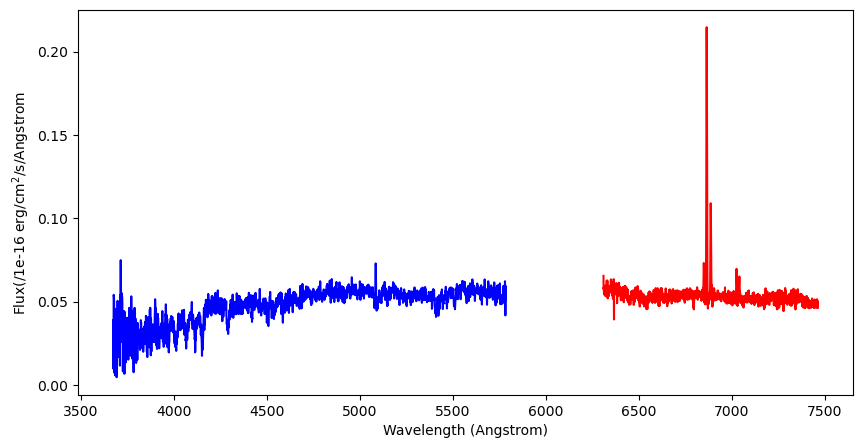

In [77]:
#plot both the blue and red spectra on the same graph
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,24,24], 'blue')
plt.plot(SAMI_WAVE(red[0].header), redspec[:,24,24], 'red')
#plot labels
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')

In [78]:
## GET plt.imshow() to work here

### Correcting spectra for foreground extinction due to dust ###

In [79]:
#DUST_CORR is a function that corrects the individual blue or red spectra for a single pixel
def DUST_CORR(colour, pixel):
    test = pixel*(colour[4].data)
    return test
    

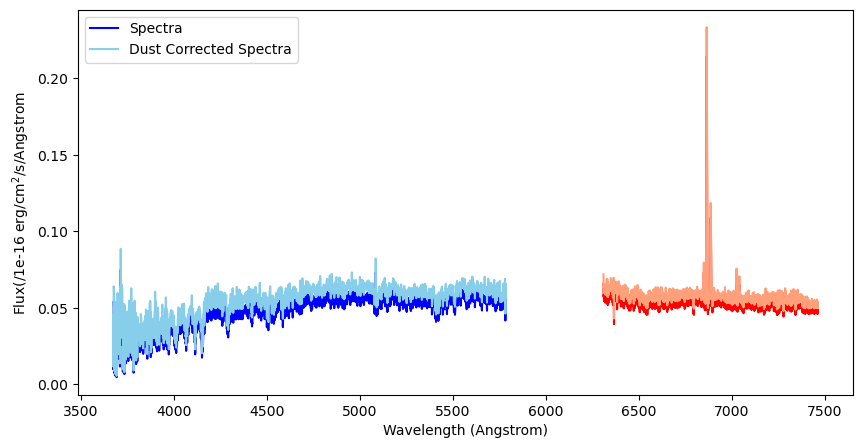

In [80]:
#Here we plot the original test pixel spectra against the newly dust corrected spectra for the same pixel. 
#Lighter colours show the dust corrected spectra.
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(SAMI_WAVE(blue[0].header), bluespec[:,24,24], 'blue', label='Spectra')
plt.plot(SAMI_WAVE(blue[0].header), DUST_CORR(blue,bluespec[:,24,24]), 'skyblue', label='Dust Corrected Spectra')
plt.plot(SAMI_WAVE(red[0].header), redspec[:,24,24], 'red')
plt.plot(SAMI_WAVE(red[0].header), DUST_CORR(red,redspec[:,24,24]), 'lightsalmon')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

In [81]:
dcorr_b=DUST_CORR(blue,bluespec[:,24,24])
dcorr_r=DUST_CORR(red,redspec[:,24,24])

### Find the quadrature difference between blue and red arm instrumental resolutions ###

 $\sqrt{FWHM_{blue}^2 - FWHM_{red}^2}$

In [82]:
#Blue-arm FWHM is 2.66 Angstrom
#Red-arm FWHM is 1.59 Angstrom
dFWHM=np.sqrt((2.66**2)-(1.59**2))
dFWHM

2.1324868112136124

### Convolve red arm flux and variance ###

In [83]:
#first we define the standard deviation so we can feed it into our kernel 
sd=dFWHM/2.355
sdpix=sd/red[0].header['CDELT3']
print(sd, sdpix)

0.9055145695174575 1.519334691641124


In [84]:
#define our gaussian kernel 
gauss = Gaussian1DKernel(sdpix)
gauss.array


array([1.07837940e-04, 1.16824163e-03, 8.20645123e-03, 3.73800369e-02,
       1.10404221e-01, 2.11442970e-01, 2.62580482e-01, 2.11442970e-01,
       1.10404221e-01, 3.73800369e-02, 8.20645123e-03, 1.16824163e-03,
       1.07837940e-04])

In [85]:
r_smooth= convolve(redspec[:,24,24], gauss.array)
rvar_smooth= convolve(redvar[:,24,24], gauss.array)

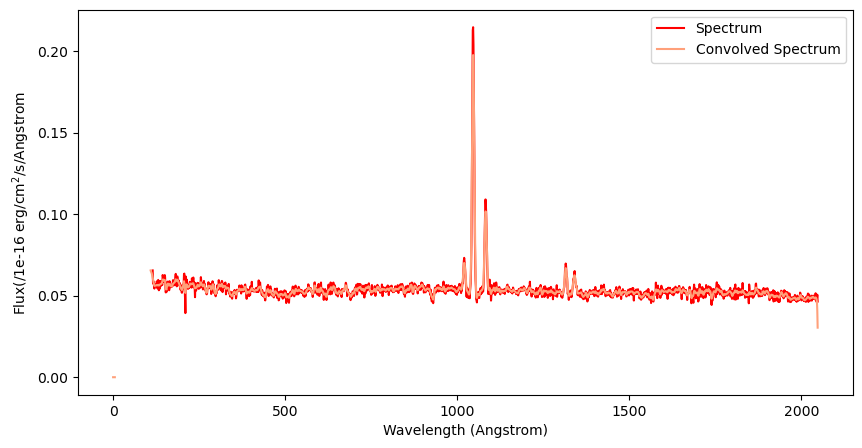

In [86]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(redspec[:,24,24], 'red', label='Spectrum')
plt.plot(r_smooth, 'lightsalmon', label='Convolved Spectrum')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

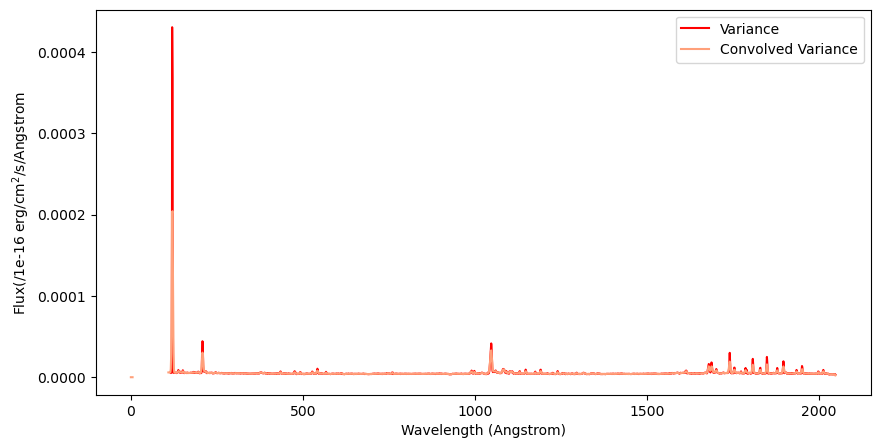

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(redvar[:,24,24], 'red', label='Variance')
plt.plot(rvar_smooth, 'lightsalmon', label='Convolved Variance')


plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux(/1e-16 erg/cm$^2$/s/Angstrom')
plt.legend()

### Create a wavelength vector of blue arm pixel size ###

SAMI_WAVE above can be used for the blue arm and red arm seperately but this needs to be adapted for the red to give blue pixel size over these wavelengths.

In [161]:
x_comb=np.arange(3650, 7800, blue[0].header['CDELT3'])

In [162]:
#Lengthy approach 
# def SAMI_BLUE_WAVE(header, header2):
#     CDELT=header['CDELT3']
#     CRVAL=header['CRVAL3']
#     CRPIX=header['CRPIX3']
#     npix=header['NAXIS3']
#     x=CRVAL+CDELT*(np.arange(npix)+1-CRPIX)
#     CRVAL2=header2['CRVAL3']
#     CRPIX2=header2['CRPIX3']
#     npix2=header2['NAXIS3']
#     x2=CRVAL2+CDELT*(np.arange(npix2)+1-CRPIX2)
#     return x, x2
    
# SAMI_BLUE_WAVE(blue[0].header, red[0].header)

### Interpolate red flux and variance ###

#### red flux ####

In [163]:
#Set up a flag to find the NaNs:
NaNFlag=np.isnan(r_smooth)
#set up the interpolator using the original x_r and the smoothed flux. Note the “bounds_error” needs to be “False” so that any bad
#values get set to the “fill_value” (1e10 here). Note the ‘~’ to #reverse the NaNFlag boolean array and include only non-Nan pixels:
interp=interpolate.interp1d(x_r[~NaNFlag],r_smooth[~NaNFlag],kind='cubic',bounds_error=False,fill_value=1e10)	
#do the interpolation
r_interp=interp(x_comb)


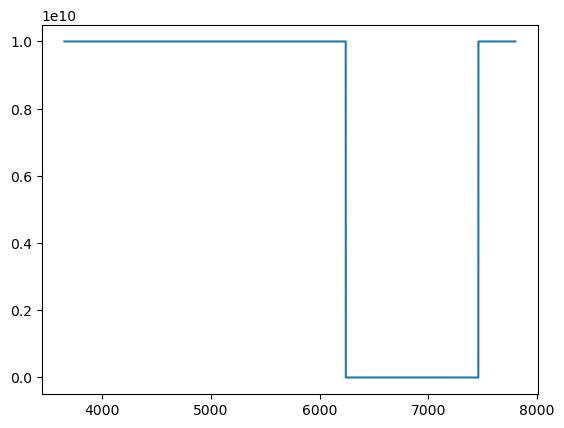

In [164]:
plt.plot(x_comb, r_interp)

In [165]:
#copy into a more appropriately named vector
BR_interp=r_interp.copy()
#fill in the blue part
BR_interp[x_comb < np.max(x_b)]=bluespec[:,24,24]


In [166]:
BR_interp

array([   nan,    nan,    nan, ..., 1.e+10, 1.e+10, 1.e+10])

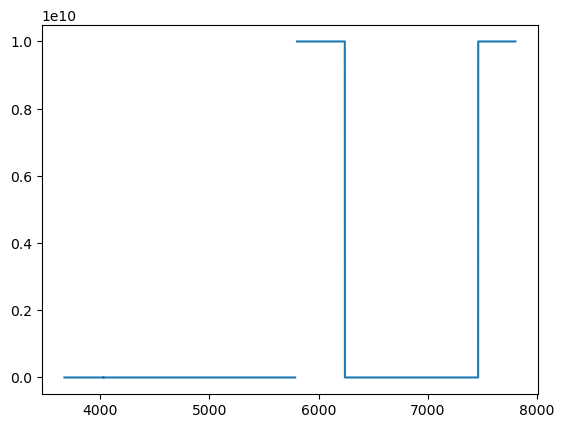

In [167]:
plt.plot(x_comb, BR_interp)

#### Variance ####

In [168]:
#Set up a flag to find the NaNs:
NaNFlag=np.isnan(rvar_smooth)
#set up the interpolator using the original 
var_interp=interpolate.interp1d(x_r[~NaNFlag],rvar_smooth[~NaNFlag],kind='cubic',bounds_error=False,fill_value=1e10)	
#do the interpolation
rvar_interp=var_interp(x_comb)

BRvar_interp=rvar_interp.copy()
#fill in the blue part
BRvar_interp[x_comb < np.max(x_b)]=bluevar[:,24,24]

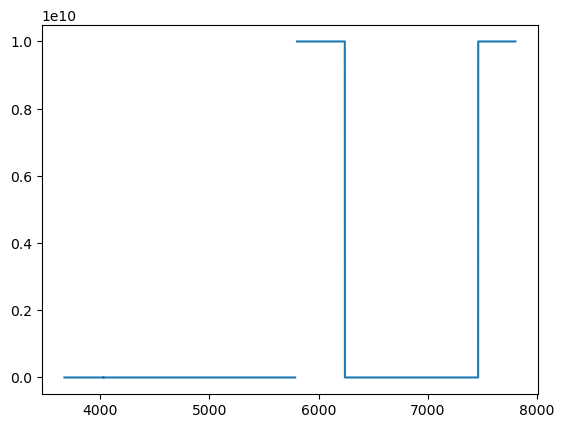

In [169]:
plt.plot(x_comb, BRvar_interp)

### Replace flux free regions and region extremes with nans ###

In [170]:
BR_interp= np.where(BR_interp==1.00000000e+10, np.nan, BR_interp)

In [171]:
with np.printoptions(threshold=np.inf):
    print(BR_interp)

[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan  3.87542070e-02  9.83865991e-03  1.35386196e-02
  5.41128906e-02  5.29446462e-02  5.05657156e-02  4.11058773e-02
  7.27386344e-03  2.73352868e-02  3.09862981e-02  5.89276897e-03
  4.36052967e-02  4.54888556e-02  3.17576063e-02  3.25831306e-02
  1.34526839e-02  2.58028617e-02  3.74581839e-02  4.68678703e-03
  1.73988044e-02  2.69368158e-02  2.35213135e-02  3.02220228e-02
  5.04868269e-02  2.74357020e-02  3.84391719e-02  1.67524905e-02
  3.42009811e-02  3.58360138e-02  4.96742854e-02  2.66088012e-02
  2.06583406e-02  2.54306762e-02  2.18490512e-02  2.25504329e-02
  1.16342062e-02  5.38961587e-02  4.18121160e-02  2.78509408e-02
  7.49037222e-02  3.89059

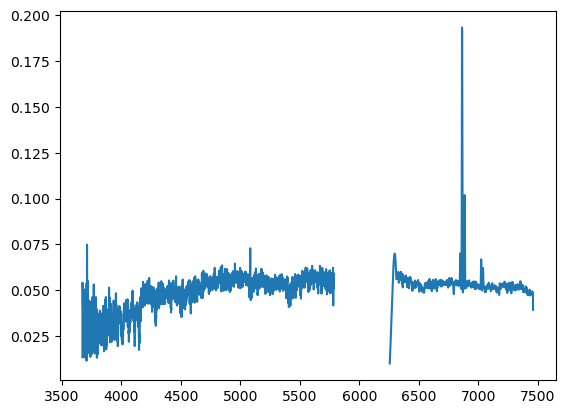

In [145]:
plt.plot(x_comb, BR_interp)

In [157]:
BR_interp=np.where(BR_interp<1e-02, np.nan, BR_interp)

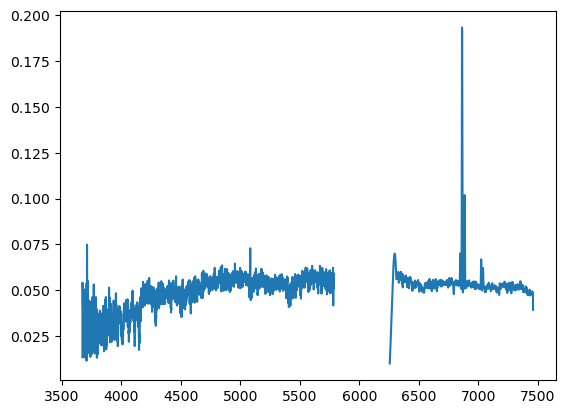

In [158]:
plt.plot(x_comb, BR_interp)

In [159]:
BR_interp

array([nan, nan, nan, ..., nan, nan, nan])